# PREDIKTIF HARGA SAHAM MENGGUNAKAN ALGORITMA GENERALIZED LINEAR MODEL DAN ARIMA

GENERALIZED LINEAR MODEL

IMPORT LIBRARY

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import yfinance as yf
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from IPython.display import display
import ipywidgets as widgets

In [53]:
!pip install yfinance matplotlib ipywidgets scikit-learn pandas statsmodels --quiet

PILIH SAHAM LQ45

In [57]:
def load_data(folder_path='./lq45/'):
    file_list = [f for f in os.listdir(folder_path) if f.endswith(".csv")]

    saham_dropdown = widgets.Dropdown(
        options=file_list,
        description='Pilih Saham:',
        layout=widgets.Layout(width='300px')
    )
    output = widgets.Output()

    def on_saham_change(change):
        if change['type'] == 'change' and change['name'] == 'value':
            df = pd.read_csv(os.path.join(folder_path, change['new']))

            # Normalisasi nama kolom tanggal
            if 'date' not in df.columns:
                for col in df.columns:
                    if col.lower() == 'tanggal':
                        df.rename(columns={col: 'date'}, inplace=True)

            df['date'] = pd.to_datetime(df['date'])
            df.sort_values('date', inplace=True)

            min_date = df['date'].min()
            max_date = df['date'].max()

            start_date = widgets.DatePicker(
                description='Start Date',
                value=min_date
            )
            end_date = widgets.DatePicker(
                description='End Date',
                value=max_date
            )

            def on_date_change(change):
                if start_date.value and end_date.value:
                    df_filtered = df[(df['date'] >= pd.to_datetime(start_date.value)) & 
                                     (df['date'] <= pd.to_datetime(end_date.value))]

                    if df_filtered.empty:
                        with output:
                            output.clear_output()
                            print(" Data kosong untuk rentang tanggal.")
                        return

                    output.clear_output()
                    with output:
                        display(df_filtered.head())
                        plt.figure(figsize=(12, 4))
                        plt.plot(df_filtered['date'], df_filtered['close'], label='Harga Penutupan')
                        plt.title(f'Harga Saham {change["new"]}')
                        plt.xlabel("Tanggal")
                        plt.ylabel("Harga")
                        plt.grid(True)
                        plt.legend()
                        plt.show()

                    globals()['dataframe_aktif'] = df_filtered.reset_index(drop=True)

            start_date.observe(on_date_change, names='value')
            end_date.observe(on_date_change, names='value')
            display(widgets.HBox([start_date, end_date]))

    saham_dropdown.observe(on_saham_change)
    display(saham_dropdown, output)

load_data()


Dropdown(description='Pilih Saham:', layout=Layout(width='300px'), options=('ACES.csv', 'ADRO.csv', 'AKRA.csv'…

Output()

C:\Users\ADVAN\anaconda3\Lib\site-packages\traitlets\traitlets.py:711: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  silent = bool(old_value == new_value)


In [58]:
# Asumsikan dataframe_aktif sudah tersedia dari cell sebelumnya
df = dataframe_aktif.copy()

# Cek dulu kolom yang tersedia
print("Kolom tersedia:", df.columns.tolist())

# Pastikan semua nilai numerik yang dibutuhkan tidak null
df = df[['date', 'open_price', 'high', 'low', 'volume', 'close']].dropna()

# Buat kolom ordinal dari tanggal untuk model GLM
df['date_ordinal'] = pd.to_datetime(df['date']).map(pd.Timestamp.toordinal)

# Fitur dan target
X = df[['date_ordinal', 'open_price', 'high', 'low', 'volume']]
y = df['close']

print("Jumlah data:", len(df))
display(df.head())


Kolom tersedia: ['date', 'previous', 'open_price', 'first_trade', 'high', 'low', 'close', 'change', 'volume', 'value', 'frequency', 'index_individual', 'offer', 'offer_volume', 'bid', 'bid_volume', 'listed_shares', 'tradeble_shares', 'weight_for_index', 'foreign_sell', 'foreign_buy', 'delisting_date', 'non_regular_volume', 'non_regular_value', 'non_regular_frequency']
Jumlah data: 534


,date,open_price,high,low,volume,close,date_ordinal
0,2022-11-29,4820.0,4860.0,4790.0,166057400.0,4850.0,738488
1,2022-11-30,4810.0,4980.0,4800.0,395465800.0,4980.0,738489
2,2022-12-01,5000.0,5025.0,4900.0,240171100.0,4940.0,738490
3,2022-12-02,4900.0,4930.0,4860.0,200044500.0,4890.0,738491
4,2022-12-05,4910.0,4930.0,4860.0,106809900.0,4890.0,738494


FUNGSI FITUR GLM

In [59]:
# Cek jumlah data dulu
n = len(df)
split_index = int(n * 0.9)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print(f"Train: {len(X_train)} data | Test: {len(X_test)} data")


Train: 480 data | Test: 54 data


In [60]:
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

model_glm = sm.GLM(y_train, X_train_const, family=sm.families.Gaussian())
results_glm = model_glm.fit()

# Prediksi
y_pred = results_glm.predict(X_test_const)



FUNGSI LATIH MODEL GLM

In [36]:
# Tampilkan ringkasan model
print(results_glm.summary())

                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     1598.
Date:                Wed, 23 Apr 2025   Prob (F-statistic):          1.04e-217
Time:                        09:14:49   Log-Likelihood:                -9902.3
No. Observations:                1120   AIC:                         1.981e+04
Df Residuals:                    1118   BIC:                         1.982e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6524.3357    100.008     65.238      0.0

EVALUASI MODEL

In [61]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared: {r2:.4f}")



Mean Absolute Error (MAE): 26.06
Mean Squared Error (MSE): 1037.98
Root Mean Squared Error (RMSE): 32.22
R-squared: 0.9451


VISUALISASI PREDIKSI DAN AKTUAL

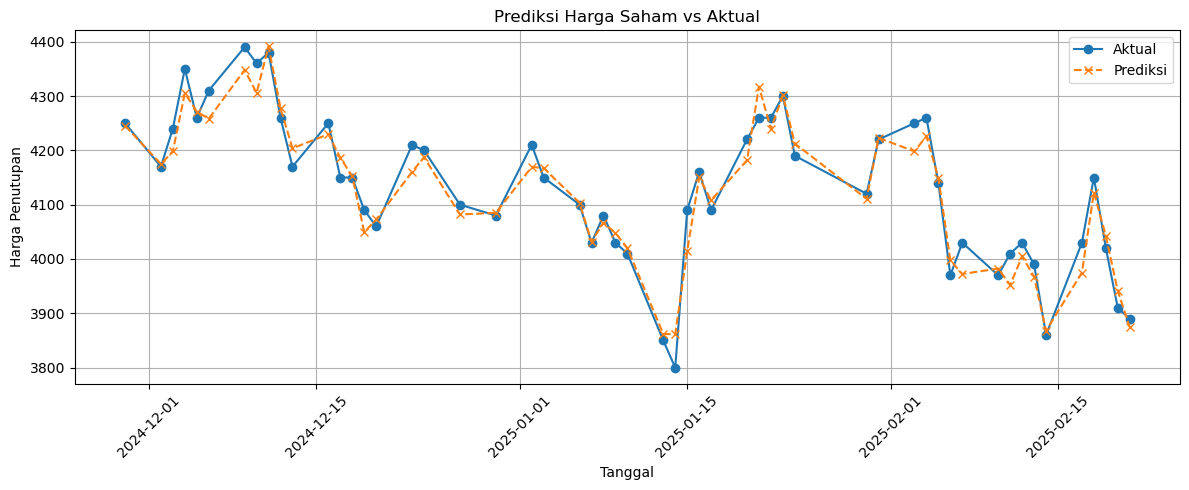

In [62]:
plt.figure(figsize=(12, 5))
plt.plot(df['date'].iloc[split_index:], y_test, label='Aktual', marker='o')
plt.plot(df['date'].iloc[split_index:], y_pred, label='Prediksi', linestyle='--', marker='x')
plt.title('Prediksi Harga Saham vs Aktual')
plt.xlabel('Tanggal')
plt.ylabel('Harga Penutupan')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()